# Early-Warning Operational Failure Risk System
## Data Understanding

**Objective:**  
Understand the dataset structure, identify the target variable, and assess data quality before analysis.


In [1]:
import pandas as pd

df = pd.read_csv("ai4i2020.csv")
df.head()


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [2]:
df.shape


(10000, 14)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

## Data Dictionary

Each row represents a single machine operating record with sensor readings and failure information.

| Column Name | Description | Type |
|------------|------------|------|
| UDI | Unique identifier | ID |
| Product ID | Product identifier | Categorical |
| Type | Machine type (L/M/H) | Categorical |
| Air temperature [K] | Air temperature | Numeric |
| Process temperature [K] | Process temperature | Numeric |
| Rotational speed [rpm] | Rotational speed | Numeric |
| Torque [Nm] | Torque | Numeric |
| Tool wear [min] | Tool wear time | Numeric |
| Machine failure | Failure occurred (1/0) | Target |


## Target Variable

The primary target variable is **Machine failure**, which indicates whether a machine failure occurred (1) or not (0).

This project focuses on predicting failure risk in advance to support preventive maintenance decisions.


In [5]:
df["Machine failure"].value_counts(normalize=True)


,proportion
Machine failure,
0,0.9661
1,0.0339


In [6]:
#Step 3: EDA
features = df.drop(columns=["Machine failure"])
target = df["Machine failure"]


In [7]:
df.groupby("Type")["Machine failure"].mean()


,Machine failure
Type,
H,0.020937
L,0.039167
M,0.027694


### Failure Rate by Machine Type

The failure rate varies across machine types.  
Machine type **L** shows the highest failure rate (3.9%), followed by **M** (2.8%), while **H** has the lowest failure rate (2.1%).

This suggests that machine type may be a meaningful predictor of failure risk and should be included as a categorical feature in the predictive model.


<Figure size 640x480 with 0 Axes>

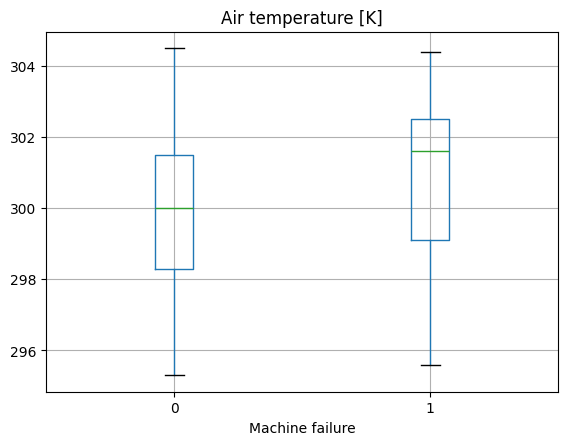

<Figure size 640x480 with 0 Axes>

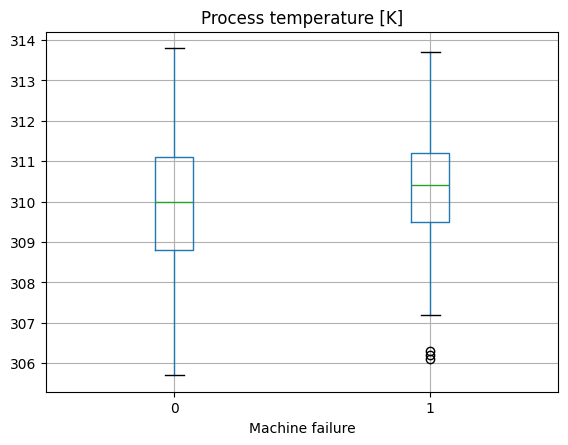

<Figure size 640x480 with 0 Axes>

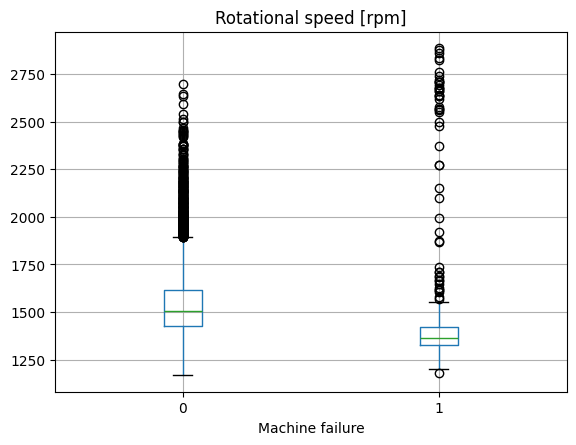

<Figure size 640x480 with 0 Axes>

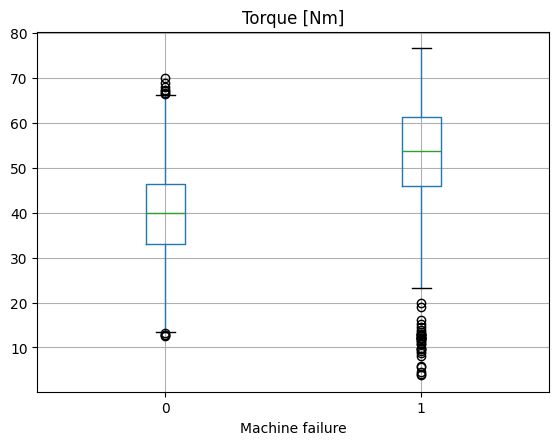

<Figure size 640x480 with 0 Axes>

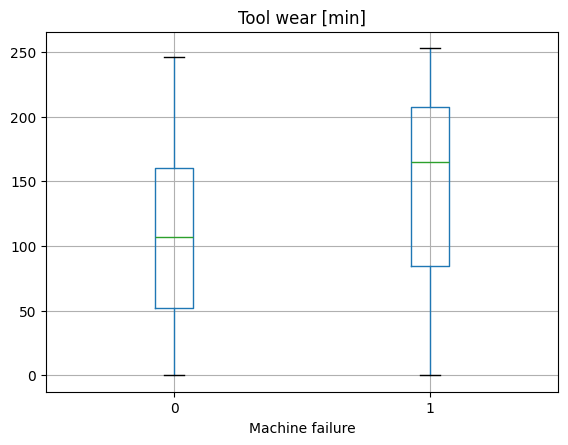

In [8]:
import matplotlib.pyplot as plt

sensor_cols = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]"
]

for col in sensor_cols:
    plt.figure()
    df.boxplot(column=col, by="Machine failure")
    plt.title(col)
    plt.suptitle("")
    plt.show()


### Sensor Distribution Insights

- Failed machines tend to operate at higher torque values compared to non-failed machines, suggesting increased mechanical stress prior to failure.
- Tool wear shows higher median values and wider variability for failed machines, indicating wear accumulation as a key failure driver.
- Temperature-related variables show moderate separation between failed and non-failed cases, suggesting thermal conditions may contribute to failure risk.


In [9]:
#Step 4: Feature engineeering
df["Temp_diff"] = df["Process temperature [K]"] - df["Air temperature [K]"]
df["High_temp_diff"] = (df["Temp_diff"] > df["Temp_diff"].quantile(0.75)).astype(int)


Created temperature difference features to capture thermal stress, which may contribute to increased failure risk.


In [10]:
df["High_tool_wear"] = (df["Tool wear [min]"] > df["Tool wear [min]"].quantile(0.75)).astype(int)


Engineered a high tool wear indicator to represent elevated mechanical wear conditions.


In [12]:
df["Power_load"] = df["Rotational speed [rpm]"] * df["Torque [Nm]"]


Created an interaction feature combining rotational speed and torque to approximate mechanical load on the system.


In [13]:
df["Type"].value_counts()


,count
Type,
L,6000
M,2997
H,1003


### Machine Type Distribution

The dataset is imbalanced across machine types, with Type L representing the majority of records, followed by M and H.

This imbalance may influence model learning and should be considered during categorical encoding and model evaluation to avoid bias toward dominant machine types.


In [14]:
#Step 5 : Baseline modeling
feature_cols = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]",
    "Temp_diff",
    "High_temp_diff",
    "High_tool_wear",
    "Power_load",
    "Type"
]

X = df[feature_cols]
y = df["Machine failure"]


In [15]:
X = pd.get_dummies(X, columns=["Type"], drop_first=True)


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)


Used a stratified train-test split to preserve the failure rate distribution across training and test sets.


In [17]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

log_reg.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = log_reg.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[2066  349]
 [  11   74]]
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      2415
           1       0.17      0.87      0.29        85

    accuracy                           0.86      2500
   macro avg       0.58      0.86      0.61      2500
weighted avg       0.97      0.86      0.90      2500



In [19]:
y_risk = log_reg.predict_proba(X_test)[:, 1]

risk_df = X_test.copy()
risk_df["Failure_risk_score"] = y_risk
risk_df["Actual_failure"] = y_test.values

risk_df.head()


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Temp_diff,High_temp_diff,High_tool_wear,Power_load,Type_L,Type_M,Failure_risk_score,Actual_failure
1390,298.9,310.2,1409,54.8,140,11.3,1,0,77213.2,True,False,0.382681,0
2925,300.7,309.6,1388,51.1,160,8.9,0,0,70926.8,False,True,0.652626,0
2488,298.9,308.7,1356,50.7,185,9.8,0,1,68749.2,True,False,0.846181,0
5844,301.4,311.1,1462,37.1,41,9.7,0,0,54240.2,True,False,0.024714,0
7978,301.2,312.4,1480,53.5,97,11.2,1,0,79180.0,True,False,0.164047,0


### Risk Scoring Approach

Instead of relying solely on binary predictions, the model outputs a continuous failure risk score between 0 and 1.  
This allows maintenance teams to prioritize inspections based on risk thresholds rather than a strict fail/no-fail classification.


### Baseline Model Performance

The baseline logistic regression model achieves a recall of approximately 87% for failure cases, indicating strong ability to identify machines at risk of failure.

While precision for failures is lower, this tradeoff is acceptable in a maintenance context where false positives result in additional inspections, whereas false negatives could lead to costly unplanned downtime.


### Risk Scoring Output

The model outputs a continuous failure risk score rather than a binary decision, allowing maintenance teams to rank machines by risk and prioritize inspections accordingly.


In [20]:
#Step 6 :EXPLAINABILITY & FAILURE DRIVERS

In [21]:
import pandas as pd

coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": log_reg.coef_[0]
})

coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df.sort_values(by="Abs_Coefficient", ascending=False).head(10)


,Feature,Coefficient,Abs_Coefficient
7,High_tool_wear,1.460316,1.460316
6,High_temp_diff,1.192545,1.192545
5,Temp_diff,-0.804148,0.804148
3,Torque [Nm],0.743903,0.743903
1,Process temperature [K],-0.432619,0.432619
0,Air temperature [K],0.371529,0.371529
9,Type_L,0.174478,0.174478
10,Type_M,-0.086067,0.086067
2,Rotational speed [rpm],0.014294,0.014294
4,Tool wear [min],0.008679,0.008679


### Key Failure Drivers (Model Explainability)

Model coefficients indicate that high tool wear and increased mechanical load (speed × torque) are among the strongest contributors to failure risk.

Thermal stress, captured through the temperature difference between process and air temperature, also shows a positive association with failure probability.

Machine type plays a secondary but meaningful role, suggesting that design or operational differences influence failure behavior.


<Axes: title={'center': 'Top Failure Risk Drivers'}, ylabel='Feature'>

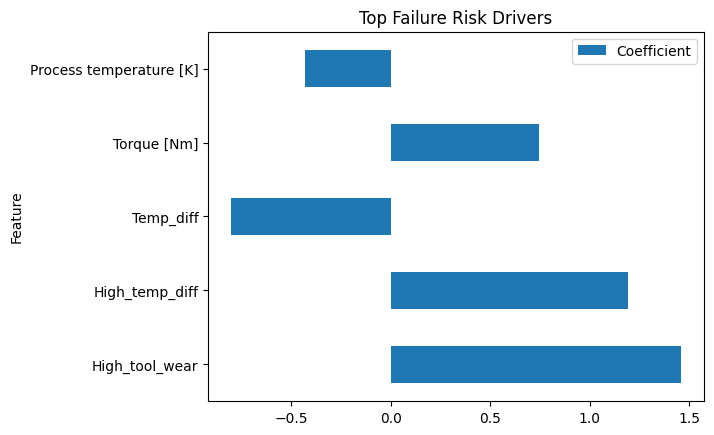

In [22]:
top_features = coef_df.sort_values(
    by="Abs_Coefficient", ascending=False
).head(5)

top_features.plot(
    x="Feature", y="Coefficient",
    kind="barh", title="Top Failure Risk Drivers"
)


In [25]:
#Step 7:DECISION THRESHOLDS, ACTIONS & STORY
# Define risk thresholds
def assign_action(risk):
    if risk >= 0.7:
        return "Shutdown / Immediate Inspection"
    elif risk >= 0.4:
        return "Schedule Inspection"
    else:
        return "Monitor"

risk_df["Recommended_action"] = risk_df["Failure_risk_score"].apply(assign_action)

risk_df[["Failure_risk_score", "Recommended_action", "Actual_failure"]].head(10)


,Failure_risk_score,Recommended_action,Actual_failure
1390,0.382681,Monitor,0
2925,0.652626,Schedule Inspection,0
2488,0.846181,Shutdown / Immediate Inspection,0
5844,0.024714,Monitor,0
7978,0.164047,Monitor,0
4161,0.095687,Monitor,0
3132,0.057656,Monitor,0
1092,0.003535,Monitor,0
67,0.378317,Monitor,0
5,0.014944,Monitor,0


In [26]:
pd.crosstab(
    risk_df["Recommended_action"],
    risk_df["Actual_failure"],
    normalize="index"
)


Actual_failure,0,1
Recommended_action,,
Monitor,0.995406,0.004594
Schedule Inspection,0.950877,0.049123
Shutdown / Immediate Inspection,0.757812,0.242188


### Action-Level Outcome Validation

The decision thresholds effectively separate low-risk and high-risk machines.

Only ~0.5% of machines classified under "Monitor" experienced failures, indicating strong risk containment.  
Machines flagged for inspection and shutdown show progressively higher failure rates, with over 24% of shutdown recommendations corresponding to actual failures.

This demonstrates that the risk scoring framework successfully prioritizes machines requiring immediate attention while minimizing unnecessary interventions.
